In [459]:
include("MySimplexQuad.jl")
using .MySimplexQuad

include("OrthoPols.jl")
using .OrthoPols

###############################################################

function rse(vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################


function transform_triangle(point::Vector{T}) where T <: AbstractFloat
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[0, 2 / sqrt(T(3))]    # (0,0) maps to this
    v2 = T[-1, -1 / sqrt(T(3))]  # (1,0) maps to this
    v3 = T[1, -1 / sqrt(T(3))]   # (0,1) maps to this
    
    # Extract x and y from the input point
    x, y = point

    # Compute the affine transformation
    new_x = (v2[1] - v1[1]) * x + (v3[1] - v1[1]) * y + v1[1]
    new_y = (v2[2] - v1[2]) * x + (v3[2] - v1[2]) * y + v1[2]

    return T[new_x, new_y]
end

###############################################################

Trans([0.0,1.0])

2-element Vector{Float64}:
 -1.0
 -0.577350269189626

In [461]:
# X, W = mysimplexquad(BigFloat, 10, 2)

In [462]:
# order = 10
# z0 = [0.0, 0.0]
# z1 = [1.0, 0.0]
# z2 = [0.0, 1.0]

# # z0 = BigFloat.([0, 0])
# # z1 = BigFloat.([1, 0])
# # z2 = BigFloat.([0, 1])

# use_bigfloat = true
# p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
# p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
# p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

# T1 = hcat(p1, p2, p3)

# pols0, dersx0, dersy0 = ortho2eva3(1, p1)
# dersy0

# # eval_T1 = rse(ortho2eva3(order, T1[:,1])[1])
# # eval_T1

# pols0 = ortho2eva3(order, X[2,:])[1]

In [499]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches


freeparam = 1
order = 4
use_bigfloat = true

# pols0, dersx0, dersy0 = ortho2eva3(10, z0)

###############################################################

function rse(vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)
###############################################################


# vertices
T1 = hcat(p1, p2, p3)
eval_T1(order) = rse(ortho2eva3(order, Trans(T1[:,1]))[1])+
                 rse(ortho2eva3(order, Trans(T1[:,2]))[1])+
                 rse(ortho2eva3(order, Trans(T1[:,3]))[1])

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(order) = rse(ortho2eva3(order, Trans(T2[:,1]))[1])+
                 rse(ortho2eva3(order, Trans(T2[:,2]))[1])+
                 rse(ortho2eva3(order, Trans(T2[:,3]))[1])

# midpoint
T3 = hcat(b)
eval_T3(order) = rse(ortho2eva3(order, Trans(T3[:,1]))[1])


# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(order,a) = rse(6*ortho2eva3(order, Trans(T4(a)[:,1]))[1])


# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(order,a) = rse(ortho2eva3(order, Trans(T5(a)[:,1]))[1])+
                   rse(ortho2eva3(order, Trans(T5(a)[:,2]))[1])+
                   rse(ortho2eva3(order, Trans(T5(a)[:,3]))[1])


# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

# TODO!
eval_T6(order,a,b) = rse(6*ortho2eva3(order, Trans(T6(a, b)[:,1]))[1])



# System setup
function A(a,order)
    hcat(
        eval_T1(order), # trig vertices
        eval_T2(order), # edge midpoints

        # eval_T4(order,a[1]), # edge class
        # eval_T4(order,a[2]), # edge class
        


        # # eval_T3, # trig midpoint
        
        eval_T5(order,a[1]),
        # eval_T5(order,a[4]),
        # eval_T5(order,a[5]),

        # eval_T6(order,a[6],a[7]),
        # eval_T5(order,a[8]),
        )'
end


# # # System setup
# # function Aij(i, j, a)
# #     vcat(sum(eval_T1(i, j)),
# #          sum(eval_T4(a[1], i, j)), # edge class
# #          sum(eval_T5(a[2], i, j)),
# #          sum(eval_T5(a[3], i, j)))
# # end

# # A(a, order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)
# rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)



function rhs(::Type{T}, order::Int) where T <: AbstractFloat
    X, W = mysimplexquad(T, order, 2)
    w = zeros(T, div((order + 1) * (order + 2), 2))  # Initialize w with the correct type and size
    
    for k = 1:length(W)
        pols = ortho2eva3(order, Trans(T.(X[k,:])))[1]
        w .+= 2*sqrt(3)*W[k] .* pols
    end
    return w
end

# integral2(1,2)

# rhs2(order) = vcat([integral2(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
# rhs2(5)

# rhs(BigFloat, order)
# ortho2eva3(order, Trans(BigFloat.(X[5,:])))[1]
# sum(W)

rhs (generic function with 2 methods)

In [500]:
ortho2eva3(0, Trans([1.0,1.0]))[1]

1-element Vector{Float64}:
 0.7598356856515927

In [501]:
A([0.4],2)
# eval_T6(0.3,0.6)
# T1[:,1]

# Trans(BigFloat.(X[1,:]))
# Trans(T.(X[k,:])


3×6 adjoint(::Matrix{BigFloat}) with eltype BigFloat:
 2.27951   0.0          -3.45447e-77   5.88566    0.0           6.58037
 2.27951   0.0          -1.72723e-77   0.0        0.0          -1.72723e-77
 2.27951  -2.59085e-77  -6.04532e-77  -0.706279  -1.91761e-93  -0.789644

In [502]:

# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(BigFloat,order)))-rhs(BigFloat,order))

f (generic function with 1 method)

In [503]:
f([0.18858048469644503927])
a = 0.18858048469644503927
A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(BigFloat,order)))

15-element Vector{BigFloat}:
  0.594900070498880415034721259616747964341954781733624980871498440143450561644987
 -2.97904401247128962291765335297892467305772009997501426034521442942937390017987e-78
  3.086469479934355482904918043949054659308040393927675572331063171302404983856355e-17
  0.3854518783245122667592451943677489006650266815202034550454486040960537799434306
  1.489522006235644811458826676489462336528860049987507130172607214714686950089935e-78
  0.4309483009942935477447150785084033501484493163503451640866705500791904925477489
 -1.97361665826222937518294534634853759590073956623344694747870455949696020886915e-77
  0.2734707959795898905244150383610510648947204838394752651638057108358597042024702
 -3.723805015589112028647066691223655841322150124968767825431518036786717375224837e-79
 -0.1222998579342676858659413788581864806075314210233907756959688536441364232030897
 -0.04137622120173674564016496417369496008554119664931995637244358545686289612893213
  3.351424514030200825782360022101

In [504]:
rhs(BigFloat,order)

15-element Vector{BigFloat}:
  1.316074012952492384569067899315739998333703982317882066406291336816594989207151
  4.753266208643778311394285068236626170196267388082312684179061792760760097912445e-77
  3.23856320816041673451988194855014983916850013666360551938388880131322192618591e-77
 -2.6144650899211697596384463647149647139120704228273898724192852302268197841605e-78
  2.7122966868343490151604011319107504903036188644557696224840068710998233631807e-77
 -5.181701133056666775231811117680239742669600218661768831014222082101155081897456e-77
  4.374801302481802527640171259796032487819479774455283263131270100159377717866631e-77
  1.120003109488810787354792507206926819379106297262830242120261543787489249472627e-77
  4.250614210710546964057345057472071663908656429370982244191354051723603778119007e-77
  2.159042138773611156346587965700099892779000091109070346255925867542147950790607e-77
  6.789913429296483093106186089201481142295754827542084657778584831581402493484893e-77
  1.3061361563744889054

In [470]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.15
max_val = 0.85
a = min_val .+ (max_val - min_val) .* (use_bigfloat ? BigFloat.(rand(freeparam)) : rand(freeparam))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32] #works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################

using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")
#########################################################################################################################

BigFloat[0.2474625286109175419721058495400436614039449969862606876173515176031703077796919]

BoundsError: BoundsError: attempt to access 1-element Vector{BigFloat} at index [2]

In [471]:
# Initialize an array of strings
# bigfloat_strings = [
#     "0.3497563276590531286006952954445668121161354629231253675436650998033682105163362",
#     "0.1168256301165253085822263078463557402695806217250798718929824146309700850615156",
#     "0.5359920624522696018750290486301153617643693213794692184596278721041560647158745",
#     "0.9164715952736393185489606854094341672897032003628564147678514037992402493209116",
#     "0.1285678358785933850614611990426681246047116310691077189241495441532828989922064",
#     "0.1855704466508220428127271513465450386606911784968365895779597754013640528697462",
#     "0.1423596791302088104796922427088486702578148291092101059677756895056200393064595",
#     "0.7432798925094192858277743305767780573199273721370474792622147549960748094153323",
#     "0.2656623668160845723068798650918091304937794310308354680743438212151354872098177",
# ]
# print(a)
# Convert each string to BigFloat with full precision
# a = [parse(BigFloat, x) for x in bigfloat_strings]
# f(a)

# 0.435550025252798077216426997182572878840986513981683599296083745679164511699355
# 0.6637731214588893098777332609060568543103149065899114560422128146835452078278195
# 0.3264161593786625458414059141416173085535859770832105718160910797984164410934227
# 0.3238553555448429211620722851576776397156578278747866410510017646726121931521902
# 0.5240811779919137310112339080707195055864630881706360421103444401091930870961733
# 0.3802763277282470564714697017139324236356332292701035679786790042952726587088819
# 0.3395063654849585434670365174169452616756157045808562770409328931964232367590739

a

1-element Vector{BigFloat}:
 0.2474625286109175419721058495400436614039449969862606876173515176031703077796919

In [472]:
# println(a)

# td = TwiceDifferentiable(f, a; autodiff = :forward);

# # result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# # result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-63, iterations = 50, show_trace = true, show_every = 10, time_limit = 1000))

# println(result)

# a = Optim.minimizer(result)
# using Base.Threads

# using Distributed

# num_runs = 5

# @threads  for i in 1:num_runs
# a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))



# of = TwiceDifferentiable(f, a; autodiff = :forward)
# # method = Newton(; linesearch = LineSearches.MoreThuente())
# method = Newton(; linesearch = LineSearches.BackTracking())


of = OnceDifferentiable(f, a; autodiff = :forward);
method = Fminbox(GradientDescent())

options = Optim.Options(g_tol = 1e-20, iterations = 200, show_trace = true, show_every = 10, time_limit = 1000)


# lower_bounds = fill(BigFloat("0"), freeparam)
# upper_bounds = fill(Inf, freeparam)

result = optimize(of, a, method, options)
# result = optimize(of,lower_bounds, upper_bounds, a, method, options)
a = Optim.minimizer(result)
# # end

print(a)

MethodError: MethodError: no method matching initial_state(::Fminbox{GradientDescent{InitialPrevious{Float64}, HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Optim.var"#13#15"}, Float64, Optim.var"#51#53"}, ::Optim.Options{Float64, Nothing}, ::OnceDifferentiable{BigFloat, Vector{BigFloat}, Vector{BigFloat}}, ::Vector{BigFloat})

Closest candidates are:
  initial_state(!Matched::Newton, ::Any, ::Any, ::Any)
   @ Optim ~/.julia/packages/Optim/ZhuZN/src/multivariate/solvers/second_order/newton.jl:39
  initial_state(!Matched::MomentumGradientDescent, ::Any, ::Any, ::Any)
   @ Optim ~/.julia/packages/Optim/ZhuZN/src/multivariate/solvers/first_order/momentum_gradient_descent.jl:29
  initial_state(!Matched::Optim.KrylovTrustRegion, ::Any, ::Any, ::Array{T}) where T
   @ Optim ~/.julia/packages/Optim/ZhuZN/src/multivariate/solvers/second_order/krylov_trust_region.jl:39
  ...


In [473]:
result

UndefVarError: UndefVarError: `result` not defined

In [474]:
# result2 = optimize(f,
#             a,
#             NelderMead(),
#             autodiff = :forward,
#             Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 100, time_limit = 1000))

In [475]:
a = Optim.minimizer(result)

UndefVarError: UndefVarError: `result` not defined

In [476]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

3-element Vector{BigFloat}:
 0.01583979167744119591739537231552691238914058736301973464628663865870307316851768
 0.03701257042521246892163722627420681084797997456281847185058323208438832146424865
 0.1016544642077696871104783465153522022246749887957795002824802260580600224979899

In [477]:
f(a)

0.2837434851170644720835933451368333598149063377252304929242022310033112486530273

In [478]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

BoundsError: BoundsError: attempt to access 1-element Vector{BigFloat} at index [2]

In [479]:
println(T1)

println(T4(a[1]))
println(T4(a[2]))

println(T5(a[3]))
println(T5(a[4]))
println(T5(a[5]))

BigFloat[0.0 1.0 0.0; 0.0 0.0 1.0]
BigFloat[0.7525374713890824580278941504599563385960550030137393123826484823968296922203081 0.2474625286109175419721058495400436614039449969862606876173515176031703077796919 0.0 0.0 0.7525374713890824580278941504599563385960550030137393123826484823968296922203081 0.2474625286109175419721058495400436614039449969862606876173515176031703077796919; 0.0 0.0 0.2474625286109175419721058495400436614039449969862606876173515176031703077796919 0.7525374713890824580278941504599563385960550030137393123826484823968296922203081 0.2474625286109175419721058495400436614039449969862606876173515176031703077796919 0.7525374713890824580278941504599563385960550030137393123826484823968296922203081]


BoundsError: BoundsError: attempt to access 1-element Vector{BigFloat} at index [2]

In [480]:
integral(1,8)

0.00101010101010101

In [481]:
# using Makie
include("MySimplexQuad.jl")
using .MySimplexQuad


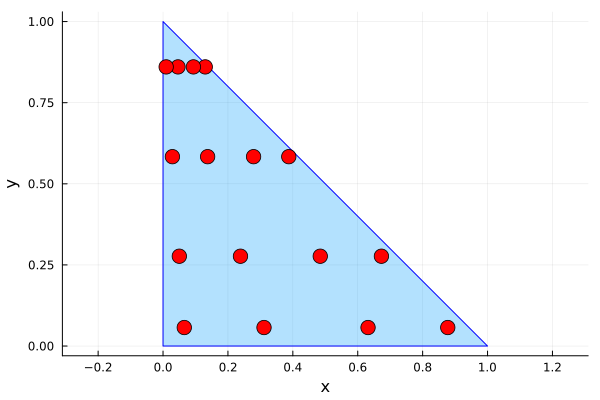

In [482]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # scene = Scene()
    # lines!(scene, vertices1; color = :black, linewidth = 2)
    # scatter!(scene, X[:, 1], X[:, 2]; color = :red, markersize = 0.3 * sqrt.(W))
    # text!(scene, "N=$npoints"; fontsize = 0.15, position = (0.5, 0.9))
    # scale!(scene, 1, 1)

    # Makie.save("figures/gauß-points-$npoints.png", scene; resolution = (300, 300))

    # x = [p1[1], p2[1], p3[1], p1[1]]
    # y = [p1[2], p2[2], p3[2], p1[2]]


    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end

In [483]:
# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(2)

6-element Vector{Float64}:
 0.5
 0.16666666666666666
 0.08333333333333333
 0.16666666666666666
 0.041666666666666664
 0.08333333333333333

In [484]:
X, W = mysimplexquad(BigFloat, 10, 2)

function integral2(i, j)
    w = 0
    for k=1:length(W)
        w += W[k]*X[k,1]^i*X[k,2]^j
    end
    return w
end

# integral2(1,2)

rhs2(order) = vcat([integral2(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs2(5)
# rhs(5)

21-element Vector{BigFloat}:
 0.4999999999999999999999999999999999999999999999999999999999999999999999999999827
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666523
 0.0833333333333333333333333333333333333333333333333333333333333333333333333333283
 0.04999999999999999999999999999999999999999999999999999999999999999999999999999471
 0.03333333333333333333333333333333333333333333333333333333333333333333333333332873
 0.0238095238095238095238095238095238095238095238095238095238095238095238095238065
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666544
 0.04166666666666666666666666666666666666666666666666666666666666666666666666666523
 0.01666666666666666666666666666666666666666666666666666666666666666666666666666598
 0.008333333333333333333333333333333333333333333333333333333333333333333333333332452
 ⋮
 0.01666666666666666666666666666666666666666666666666666666666666666666666666666652
 0.005555555555555555555555555555555555555555555